In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fraud_df = pd.read_csv("C:/Users/USER/Downloads/creditcard.csv/creditcard.csv")

In [26]:
print(fraud_df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

C:\Users\USER\AppData\Local\Temp\ipykernel_13076\1563714569.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fraud_df, x='Class', palette='coolwarm')


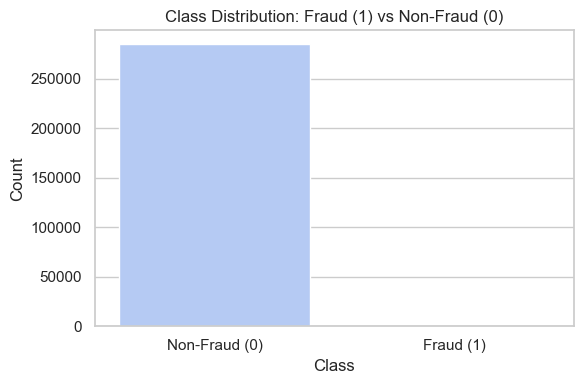

In [10]:
# Plot class distribution

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=fraud_df, x='Class', palette='coolwarm')
plt.title('Class Distribution: Fraud (1) vs Non-Fraud (0)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_13076\2954437448.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='Amount', data=fraud_df, palette='coolwarm', showfliers=False)


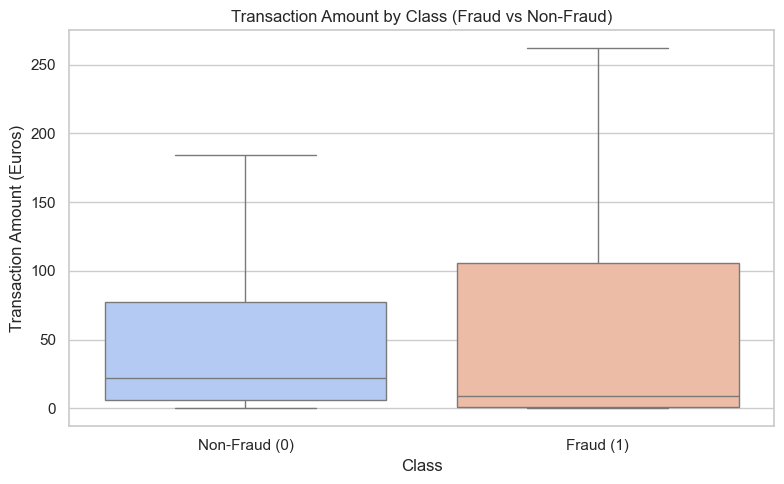

In [12]:
# Create a box plot to compare Amounts in Fraud vs Non-Fraud

plt.figure(figsize=(8, 5))

sns.boxplot(x='Class', y='Amount', data=fraud_df, palette='coolwarm', showfliers=False)
plt.title('Transaction Amount by Class (Fraud vs Non-Fraud)')
plt.xlabel('Class')
plt.ylabel('Transaction Amount (Euros)')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

In [15]:
#Fraud transactions have a slightly higher median than non-fraud.

#Fraud has a wider range — some are small, but many go much higher.

#This suggests fraudulent transactions vary more in size.

# NO extreme value(outliers): I  set showfliers=False, so extreme transactions are not shown (this helps keep the chart readable).


### The Time column shows elapsed time (in seconds) from the first transaction in the dataset. 

 If we Convert it to hours of the day, we can look for patterns (e.g., "do frauds spike at night?")

Plot both fraud and non-fraud transactions across time

In [14]:
# Plot both fraud and non-fraud transactions across time using a histogram or line plot

# Convert time in seconds to hour of day
fraud_df['Hour'] = (fraud_df['Time'] // 3600) % 24 

# Split by class
fraud = fraud_df[fraud_df['Class'] == 1]
non_fraud = fraud_df[fraud_df['Class'] == 0]

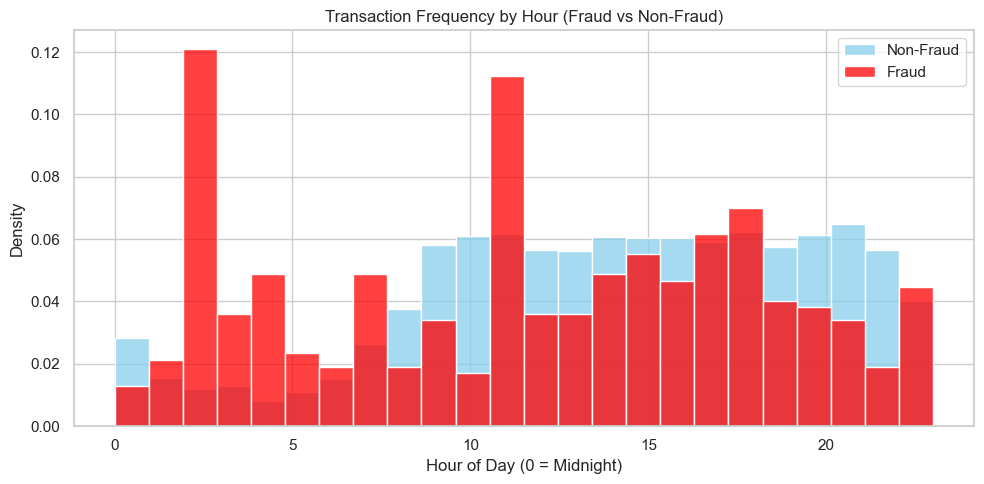

In [16]:
# Histogram Plot
plt.figure(figsize=(10, 5))

sns.histplot(non_fraud['Hour'], color='skyblue', label='Non-Fraud', bins=24, kde=False, stat='density')
sns.histplot(fraud['Hour'], color='red', label='Fraud', bins=24, kde=False, stat='density')
plt.title('Transaction Frequency by Hour (Fraud vs Non-Fraud)')
plt.xlabel('Hour of Day (0 = Midnight)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### Spike at 2 AM (Density ~0.12), Another peak at 11 AM (Density ~0.11)
- 2 AM Spike
Fraudsters may be taking advantage of off-hours when people are asleep 😴

Less likely to trigger instant customer complaints

Banks may have lower staff coverage for monitoring at night

- 11 AM Activity
Possibly during business hours

Could be fraud related to automated systems or business-targeted fraud

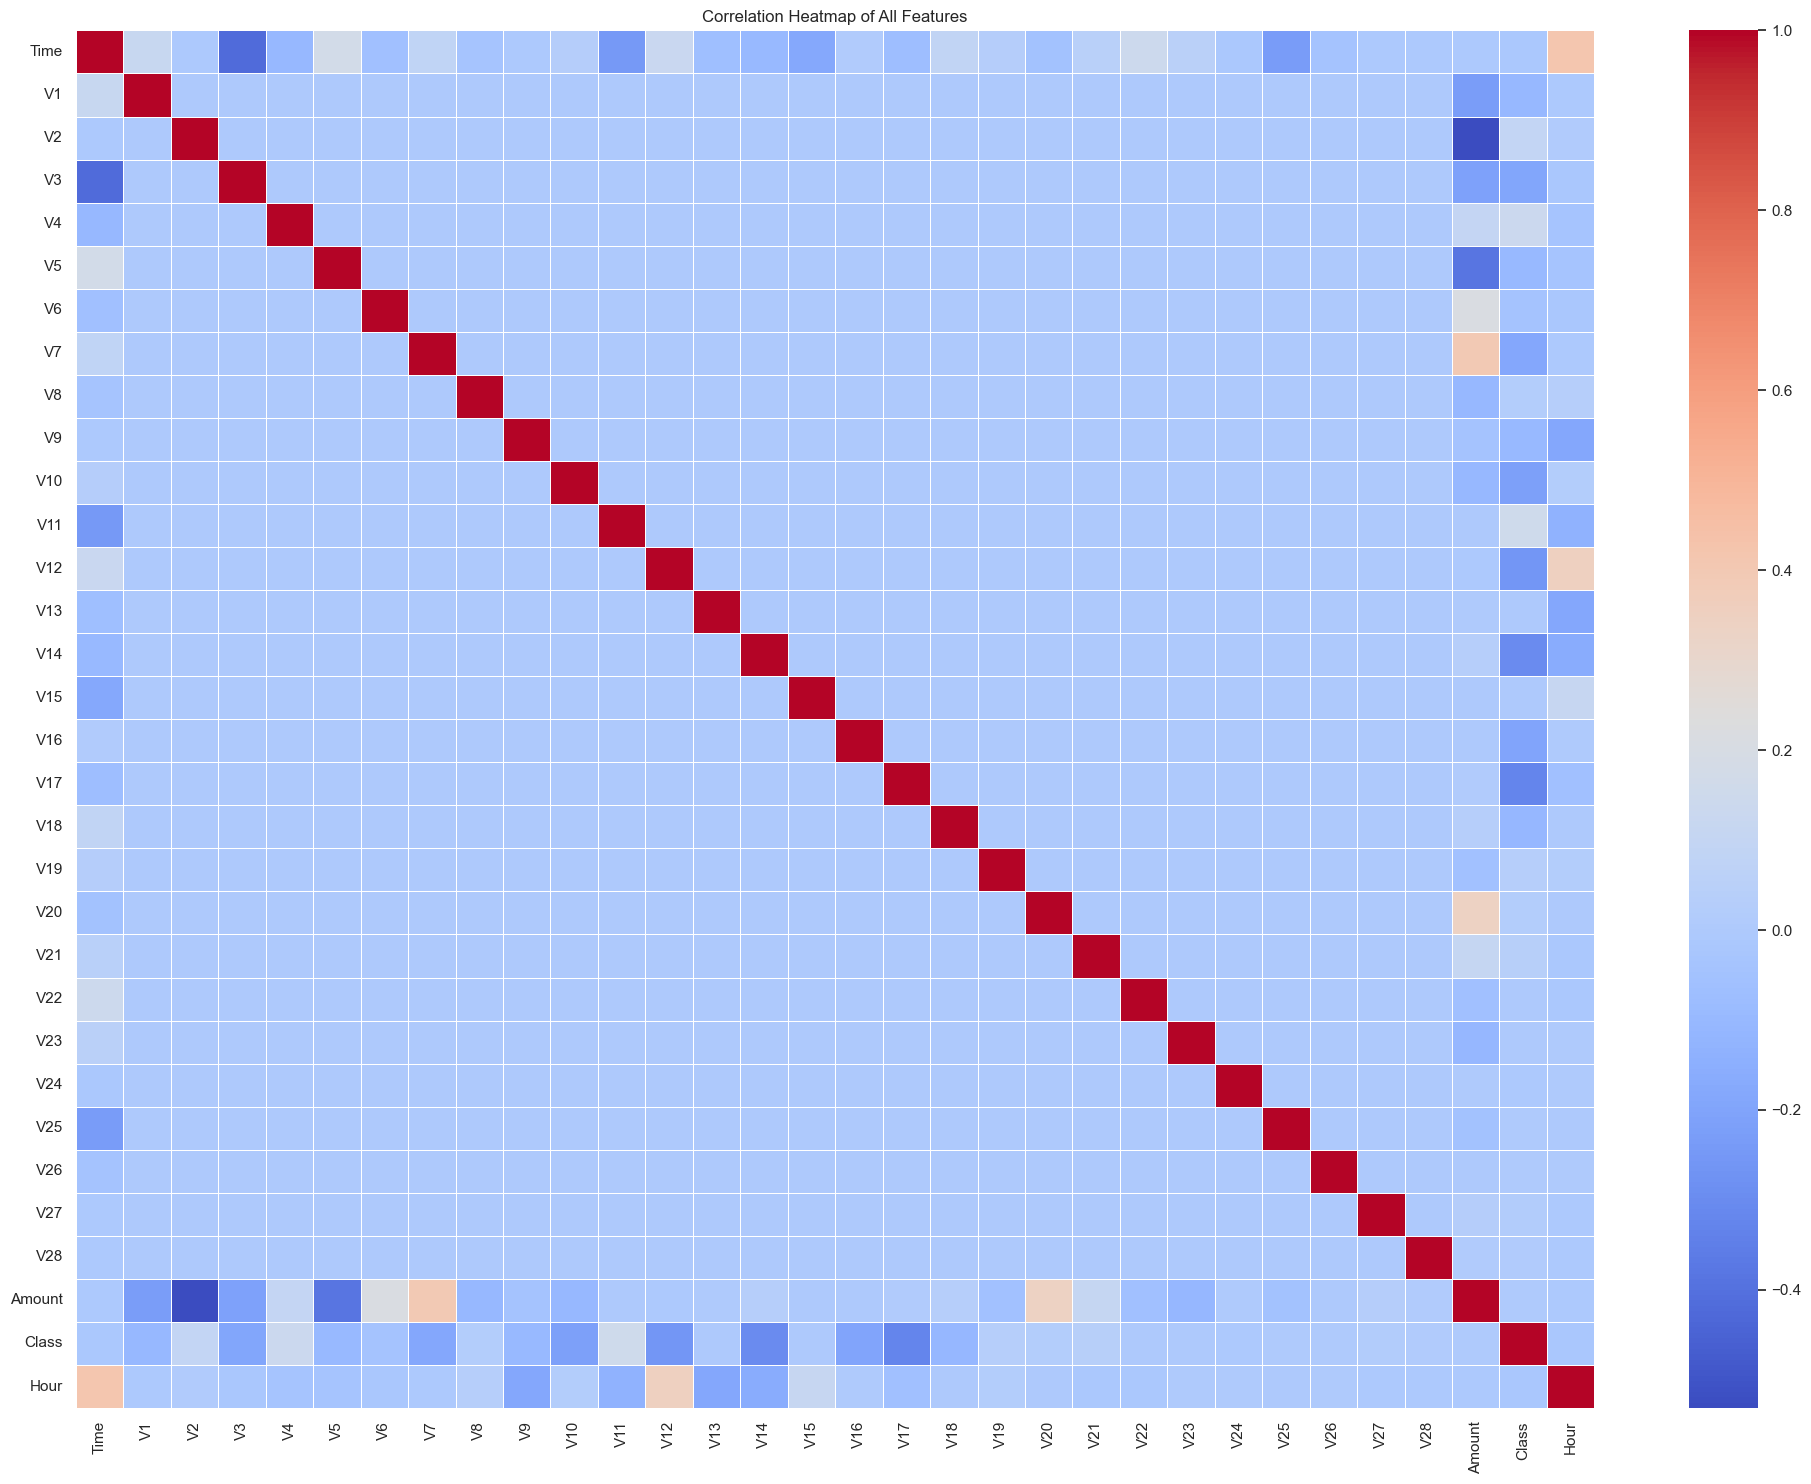

In [18]:
#Let see how features correleate with each other

# Compute correlation matrix
corr_matrix = fraud_df.corr()

# Set figure size
plt.figure(figsize=(20, 15))

# Plot the heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of All Features')
plt.tight_layout()
plt.show()

## Feature Scaling ( to standardize )
Some models (like Logistic Regression and Neural Networks) are sensitive to the scale of numbers. Features like:

Amount → can range from 0 to 25,000+
Time → can go up to 170,000+

Other features (V1 to V28) are already standardized.

So we only need to scale Amount and maybe Time to bring everything to a similar scale.

In [22]:
from sklearn.preprocessing import StandardScaler

In [24]:
# this create a copy to keep original data safe
scaled_df = fraud_df.copy()

# Columns to scale
cols_to_scale = ['Amount', 'Time']

# activating SCaler
scaler = StandardScaler()

# Apply scaler
scaled_df[cols_to_scale] = scaler.fit_transform(scaled_df[cols_to_scale])

# Preview scaled data
print(scaled_df[['Amount', 'Time']].head())

     Amount      Time
0  0.244964 -1.996583
1 -0.342475 -1.996583
2  1.160686 -1.996562
3  0.140534 -1.996562
4 -0.073403 -1.996541


# Prepare for Modeling
Define features (X) and labels (y)
Split into training & testing sets

In [26]:
from sklearn.model_selection import train_test_split

In [28]:
# Define features 
X = scaled_df.drop(['Class'], axis=1)
y = scaled_df['Class']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [30]:
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)
print("Fraud in train:", sum(y_train))
print("Fraud in test:", sum(y_test))

Training set: (227845, 31)
Testing set: (56962, 31)
Fraud in train: 394
Fraud in test: 98


# Explanation

My model will learn from 394 real fraud examples and 227,451 non-fraud

It’ll be tested on 98 fraud cases, which is enough to get a reliable measure of Recall, Precision, F1

In [32]:
# let use Logistic Regression to Detect Fraud 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [34]:
#activating the model
log_reg = LogisticRegression(max_iter=1000)

#this train the model
log_reg.fit(X_train, y_train)

#telling the model to make prediction

y_pred = log_reg.predict(X_test)

In [36]:
print("Report:")
print(classification_report(y_test, y_pred, digits=4))


Report:
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962



In [38]:
# print the Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[56851    13]
 [   35    63]]


In [40]:
# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))

ROC AUC Score: 0.9554558387789556


# insight


Precision	0.8289 -	82.9% of predicted frauds were actually fraud

Recall	0.6429	- Caught 64% of all actual frauds — this is good for a first run!

F1-Score	0.7241	- Balanced score between precision & recall

The model is catching more than half of real frauds, but it’s still missing some (35 frauds)  which we can address later using SMOTE or better models.

In [42]:
# let use SMOTE so the model can learn fraud better 

from imblearn.over_sampling import SMOTE
from collections import Counter

#activating smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [44]:
 # Print class distribution before & after
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 227451, 1: 394})
After SMOTE: Counter({0: 227451, 1: 227451})


# Insight

our training data is now perfectly balanced — 50/50 fraud vs non-fraud.
This will help the model focus more on learning fraud patterns, instead of being overwhelmed by class 0.

In [46]:
# Train new Logistic Regression model on balanced data
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

In [54]:
# Predict on the original test set (not resampled!)
y_pred_smote = log_reg_smote.predict(X_test)

In [56]:
# Evaluate

print("Report (After SMOTE):")
print(classification_report(y_test, y_pred_smote, digits=4))

Report (After SMOTE):
              precision    recall  f1-score   support

           0     0.9999    0.9721    0.9858     56864
           1     0.0536    0.9184    0.1013        98

    accuracy                         0.9720     56962
   macro avg     0.5267    0.9452    0.5435     56962
weighted avg     0.9982    0.9720    0.9842     56962



In [58]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))

Confusion Matrix:
[[55275  1589]
 [    8    90]]


In [60]:
print("ROC AUC Score:", roc_auc_score(y_test, log_reg_smote.predict_proba(X_test)[:,1]))

ROC AUC Score: 0.973522037543211


# Brief Explanation
We used Logistic Regression to build a baseline model.
It missed some frauds due to imbalance (35 missed = false negatives).
We applied SMOTE to balance the data and give the model more fraud examples to learn from.
Now we retrain the model on this new balanced data to see if it does a better job at catching fraud, especially the ones it missed before.


After using SMOTE, we retrained Logistic Regression.
so, the model catches almost all frauds (91.8% recall), but at the cost of many false positives (only 5.3% precision).
This shows SMOTE worked for detection, but we now need better techniques to balance catching fraud and not annoying legit users.


## Let tune the model to improve Precision (reduce false alarms)

the model LR use on smote is better to catch fraud (good for security) but might frustrate legit users because of false alarms so we tune our model to reduce false alarm


In [62]:
# Get predicted probabilities
y_pred_proba_smote = log_reg_smote.predict_proba(X_test)[:, 1]  # Probability of fraud class (1)

# Apply new custom i.e, 0.7 instead of 0.5
threshold = 0.7
y_pred_threshold = (y_pred_proba_smote >= threshold).astype(int)


In [64]:
 #Evaluate new predictions
print(f"Classification Report (Threshold = {threshold}):")
print(classification_report(y_test, y_pred_threshold, digits=4))

Classification Report (Threshold = 0.7):
              precision    recall  f1-score   support

           0     0.9998    0.9852    0.9925     56864
           1     0.0955    0.9082    0.1728        98

    accuracy                         0.9850     56962
   macro avg     0.5477    0.9467    0.5826     56962
weighted avg     0.9983    0.9850    0.9910     56962



In [66]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_threshold))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba_smote))

Confusion Matrix:
[[56021   843]
 [    9    89]]
ROC AUC Score: 0.973522037543211


## what does this tell us 


Precision (fraud)	9.5%	Higher than before (but still low)

Recall (fraud)	90.8%	Amazing recall! Only 9 frauds missed!

F1-Score (fraud)	17.28%	Higher than before tuning

ROC AUC Score	97.35%	🔥 Even stronger separation between classes

Now the model is a very strong fraud catcher, even though it wrongly flags some legit users.
In the real world, for fraud detection, high recall is more important than high precision —
because missing a real fraud costs more than wrongly flagging a legit user (who can always be manually verified).

# Now let try Random Forest to	See if a stronger model can also balance Precision better (to compare the both model)

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [70]:
# Activating Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on original (imbalanced) training set
rf_model.fit(X_train, y_train)

# Prediction 
y_pred_rf = rf_model.predict(X_test)

# Why Start With Imbalanced Data (orignal data) for Random Forest?
🔬 Test raw model ability | We want to see how well Random Forest performs before any boosting or balancing
🌲 RF handles imbalance better than LR | Because it can internally split based on Gini/entropy and still catch minority class patterns
🎯 We compare apples to apples | This keeps it fair when comparing with original Logistic Regression

In [72]:
print("Random Forest - Classification Report (Imbalanced):")
print(classification_report(y_test, y_pred_rf, digits=4))

Random Forest - Classification Report (Imbalanced):
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9634    0.8061    0.8778        98

    accuracy                         0.9996     56962
   macro avg     0.9815    0.9030    0.9388     56962
weighted avg     0.9996    0.9996    0.9996     56962



In [74]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Confusion Matrix:
[[56861     3]
 [   19    79]]


In [76]:
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))

ROC AUC Score: 0.9527451104245863


# Key note for RF

We implemented a Random Forest Classifier to address fraud detection and evaluate its performance on the original imbalanced dataset. 

Without any resampling or threshold tuning, the model delivered strong results:
a precision of 96.34%, a recall of 80.61%, and an F1-score of 87.78% for the fraud class. 
It only missed 19 out of 98 frauds and raised just 3 false positives, making it both effective and conservative. The ROC AUC score of 0.95 confirmed that Random Forest could separate fraudulent from non-fraudulent transactions with high reliability. Compared to our earlier Logistic Regression model, Random Forest offered better balance between catching fraud and avoiding false alarms. These results highlight its potential as a robust, production-ready model even without additional techniques like SMOTE or threshold tuning. In the next step, we'll train Random Forest on SMOTE-balanced data to explore whether further improvements in recall are possible without sacrificing precision.

# let try it with smote and see what that have for us 

Yes we are sticking to RF 

In [84]:
# Train RF on SMOTE-balanced data

rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

# Predict on original test set
y_pred_rf_smote = rf_smote.predict(X_test)

In [86]:
print("Random Forest (SMOTE) - Classification Report:")
print(classification_report(y_test, y_pred_rf_smote, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_smote))

Random Forest (SMOTE) - Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8511    0.8163    0.8333        98

    accuracy                         0.9994     56962
   macro avg     0.9254    0.9080    0.9165     56962
weighted avg     0.9994    0.9994    0.9994     56962

Confusion Matrix:
[[56850    14]
 [   18    80]]


In [88]:
print("ROC AUC Score:", roc_auc_score(y_test, rf_smote.predict_proba(X_test)[:, 1]))

ROC AUC Score: 0.9641110225041059


# Evaluation Summary for RF + SMOTE
As a curiosity-driven step, we trained a Random Forest Classifier on a SMOTE-balanced dataset to explore whether oversampling the minority class (fraud) would improve performance. The results showed a slight improvement in recall, increasing from 80.61% to 81.63%, meaning one additional fraud case was correctly identified. However, this came at the cost of a drop in precision, which fell from 96.34% to 85.11%, leading to more false positives. The F1-score also decreased slightly, reflecting a less balanced trade-off between precision and recall. Although the ROC AUC improved marginally (from 0.95 to 0.96), the overall model performance was stronger when trained on the original imbalanced data. This experiment confirms that Random Forest handles class imbalance effectively on its own, and applying SMOTE did not provide a meaningful performance gain in this case.

# Final model summary

After evaluating multiple models for fraud detection, including Logistic Regression (with and without SMOTE), Random Forest on imbalanced data, and Random Forest with SMOTE, we selected Random Forest trained on the original imbalanced dataset as the final model.

This decision was based on the following:

✅ Best overall balance of precision, recall, and F1-score for the fraud class

✅ Extremely low false positive rate (only 3 legitimate transactions flagged)

✅ High fraud detection rate (80.6% recall without oversampling)

✅ High model confidence (96.3% precision on fraud)

✅ Simpler pipeline — no need for SMOTE or threshold tuning

Although SMOTE helped improve recall slightly in other models, it introduced more false positives and reduced overall precision. Random Forest, on the other hand, demonstrated strong performance without any additional balancing techniques, making it ideal for real-world fraud detection scenarios where minimizing false alarms is just as critical as catching fraud.